**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


### 1 Training a Classifier
#### 1.1 Data Exploration


Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


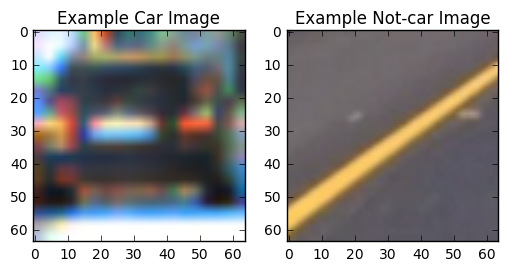

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
%matplotlib inline
#from skimage.feature import hog
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles

cars = glob.glob('../training_data/vehicles/KITTI_extracted/*.png')
cars += glob.glob('../training_data/vehicles/GTI_Far/*.png')
cars += glob.glob('../training_data/vehicles/GTI_Left/*.png')
cars += glob.glob('../training_data/vehicles/GTI_Right/*.png')
cars += glob.glob('../training_data/vehicles/GTI_MiddleClose/*.png')

notcars = glob.glob('../training_data/non-vehicles/Extras/*.png')
notcars += glob.glob('../training_data/non-vehicles/GTI/*.png')

images = []
for image in images:
    if 'non-vehicles' in image or 'Extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
   
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    img_sample = mpimg.imread(car_list[0])
    data_dict["image_shape"] = img_sample.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img_sample.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


#### 1.2 Feature Extraction

Image features refer to characteristics that set apart one image from another. One obvious feature is the color value of each pixel or histogram of all color values grouped in ranges (aka bins). A more complicated feature is called HOG, Histogram of Oriented Gradients. We are going to use skimage's hog function to extract the HOG feature from an image. Before calculating the HOG feature, we convert the image from RGB color space to the HLS color space as it handles different lighting situations better. For other HOG parameters, we chose an orientations of 9, pixels_per_cell of 8, and cells_per_block of 2.

In [2]:
from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
  features = cv2.resize(img, size).ravel()
  return features

def bin_spatial2(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

# Define a function to extract features from a single image window
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call single_img_features
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        # PNG read by mpimg.imread has values from 0-1
        image = mpimg.imread(file)
        file_features = single_img_features(image, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
            
        features.append(file_features)
    # Return list of feature vectors
    return features

## Testing
car_features = extract_features(cars[:1], hog_channel='ALL')

In [3]:
# Exploring image format: PNG image read by mpimg is [0, 1], 
# but after cv2.cvtColor, pixel values become [0, 255]
image = mpimg.imread(cars[0])
#print("Image: ", image[:,:,0])
feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#print("Image: ", feature_image[:,:,0])

#### 1.3 Training 

For training the classifier, we first scaled the extracted features to zero mean and unit variance with a StandardScaler. We then split our data into 80% training set and 20% test/validation set. Finally we fit a SVM (LinearSVC) model and calculated its accuracy. 

In [9]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
import pickle

color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
num_samples = 8000

start = time.time()
car_features = extract_features(cars[0:num_samples], color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars[0:num_samples], color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print(round(time.time()-start, 2), 'Seconds to extra features from training data ...')
print('car_features: ', len(car_features), ', noncars: ', len(notcar_features))

89.97 Seconds to extra features from training data ...
car_features:  8000 , noncars:  8000


In [10]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test_val, y_train, y_test_val = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print('Total training size:', len(X_train))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test_val, y_test_val), 4))

# Check the prediction time for a single sample
t=time.time()
idx_predict = np.random.randint(0, len(X_test_val))
print('My SVC predicts: ', svc.predict(X_test_val[idx_predict]))
print('For the actual label: ', y_test_val[idx_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict 1 labels with SVC')

# Saving Classifier Parameters
print('Saving Classifier Parameters to pickle file ...')
pickle_data = {
    'svc': svc,
    'color_space': color_space,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'hog_channel': hog_channel,
    'spatial_size': spatial_size,
    'hist_bins': hist_bins,
    'spatial_feat': spatial_feat,
    'hist_feat': hist_feat,
    'hog_feat': hog_feat,
    'X_scaler': X_scaler
}
pickle_file = 'VehicleClassifier.p'
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(pickle_data, pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
print('Data cached in pickle file.')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
Total training size: 12800
15.12 Seconds to train SVC...
Test Accuracy of SVC =  0.9806
My SVC predicts:  [ 0.]
For the actual label:  0.0
0.00102 Seconds to predict 1 labels with SVC
Saving Classifier Parameters to pickle file ...
Data cached in pickle file.


/Users/yadong/miniconda3/envs/python3/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


### 2 Sliding Window Search on Single Image

#### 2.1 Sliding Window Feature Extraction and Search
Now we trained a classifier, we can use it to search for cars on a single image. First, we need a function to create a list of search windows (i.e. bounding boxes). Then we need a function to extract features from each window. We pass the extracted features to our classifier to make a prediction. 

A few considerations here are important to make searching work. First is the fact we don't need the sliding windows to cover the entire image as we are not interested in cars in the sky (not yet). We can safely ignore the upper half of the image. Similarly we can ignore a part of the bottom as well because that was mostly the dashboard. This reduces the number of windows to search and speed up the algorithm. The second consideration is how much overlapping is necessary between windows. If the overlap is too small, you may miss areas of interests. If the overlap is too large, you end up with a lot of windows to search. Unfortunately it requires a lot of trial and error to choose the right set of parameters such as y start/stop position and overlap ratio. 

Last but not the least, we used four different window sizes (192x192, 144x144, 96x96, 64x64) to perform the sliding search. We created a function called `multi_scale_search()` to make this process easier. Through trial and error, we found that an 75% overlap worked the most reliably. 

In [11]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan)/nx_pix_per_step) 
    ny_windows = np.int((yspan)/ny_pix_per_step) 
    #nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    #ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 

    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
def multi_scale_search(image, x_start_stops, y_start_stops, xy_windows, xy_overlaps, box_colors, debug_boxes=False):
    hot_windows = []
    all_windows = []
    if debug_boxes == True:
        draw_image = np.copy(image)

    for i in range(len(x_start_stops)):
        windows = slide_window(image, x_start_stop=x_start_stops[i], y_start_stop=y_start_stops[i], 
                    xy_window=xy_windows[i], xy_overlap=xy_overlaps[i])
        all_windows += [windows]
        hot_boxes = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
        hot_windows += hot_boxes
        if debug_boxes == True:
            draw_image = draw_boxes(draw_image, hot_boxes, color=box_colors[i], thick=3) 

    if debug_boxes == True:      
        return hot_windows, all_windows, draw_image
    else:
        return hot_windows, all_windows

## Helper
def draw_two_imgs(img1, img2, title1='Original Image', title2='Undistorted Image'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=24)
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=24)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

1.95 Seconds to search  348  windows: 
0.19 Seconds to draw_boxes ...


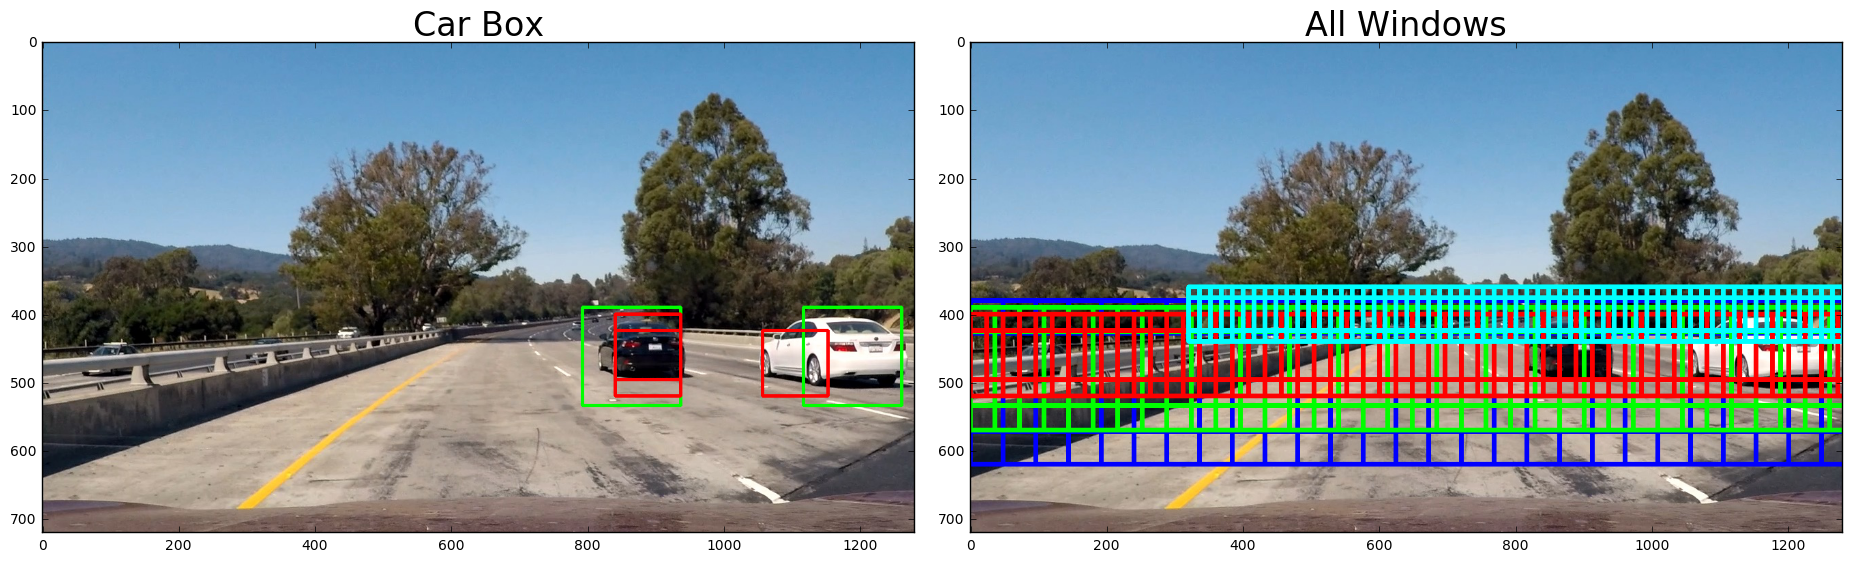

In [18]:
# Read back classifier data
with open('VehicleClassifier.p', mode='rb') as f:
    data = pickle.load(f)

svc = data['svc']
color_space = data['color_space']
orient = data['orient']
pix_per_cell = data['pix_per_cell']
cell_per_block = data['cell_per_block']
hog_channel = data['hog_channel']
spatial_size = data['spatial_size']
hist_bins = data['hist_bins']
spatial_feat = data['spatial_feat']
hist_feat = data['hist_feat']
hog_feat = data['hog_feat']
X_scaler = data['X_scaler']

image = mpimg.imread('test_images/test1.jpg')
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
# image = image.astype(np.float32)/255

x_start_stops = [[None, None],[None, None],[None, None], [320, None]]
y_start_stops = [[380, 480], [390, 462], [400, 450], [360, 392]] # Min and max in y to search in slide_window()
xy_windows = [[192, 192], [144, 144], [96, 96], [64, 64]]
xy_overlaps = [(0.75, 0.75), (0.75, 0.75), (0.75, 0.75), (0.75, 0.75)]
box_colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (0, 255, 255)]

t = time.time()
hot_windows, all_windows, image_carbox = multi_scale_search(image, x_start_stops, y_start_stops, 
                   xy_windows, xy_overlaps, box_colors, debug_boxes=True)
win_count = len(all_windows[0])+len(all_windows[1])+len(all_windows[2])+ len(all_windows[3])
print(round(time.time()-t, 2), 'Seconds to search ', win_count ,' windows: ')

t = time.time()
allwindow_draw = np.copy(image)
for i in range(len(all_windows)):
    allwindow_draw = draw_boxes(allwindow_draw, all_windows[i], color=box_colors[i], thick=6)                    

draw_two_imgs(image_carbox, allwindow_draw, title1='Car Box', title2='All Windows')
print(round(time.time()-t, 2), 'Seconds to draw_boxes ...')

In [19]:
## Run sliding window search on more test images
test_imgs = glob.glob('test_images/*.jpg')
output_dir = 'output_images/out_'
for file in test_imgs:
    image = mpimg.imread(file)
    hot_windows, all_windows, image_carbox = multi_scale_search(image, x_start_stops, y_start_stops, 
                   xy_windows, xy_overlaps, box_colors, debug_boxes=True)
    output_file = output_dir+file.split('/')[-1]
    mpimg.imsave(output_file, image_carbox)



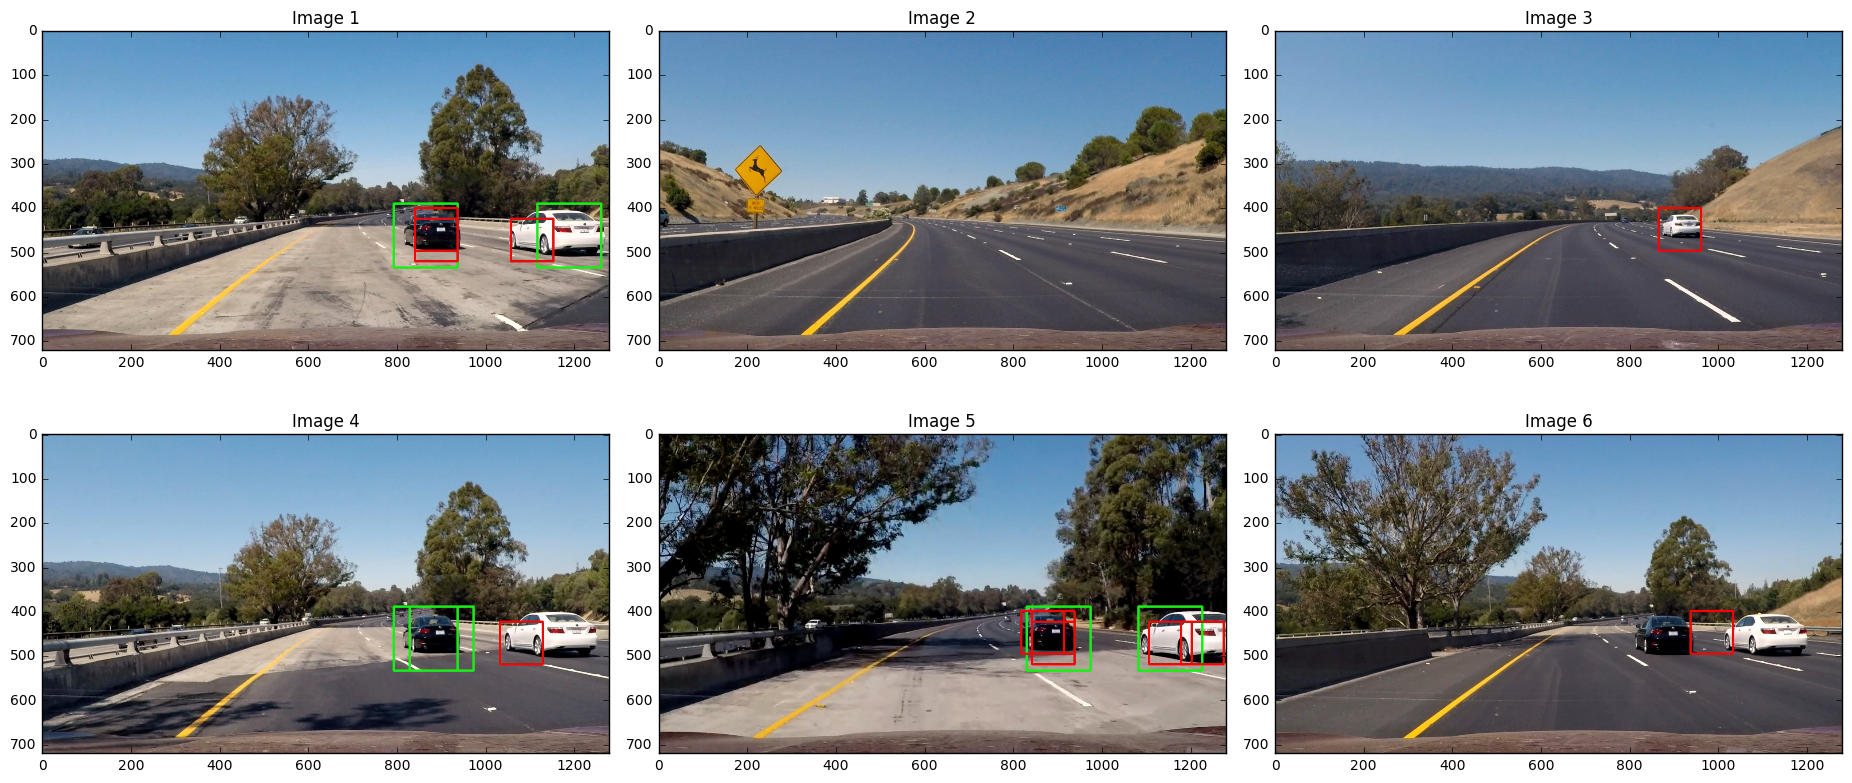

In [20]:
## Show output images
out_files = glob.glob('output_images/*.jpg')
fig, axarr = plt.subplots(2, 3, figsize=(18, 9))

for index, file in enumerate(out_files):
    fig.tight_layout()
    r = np.int(index / 3)
    c = index % 3
    image = mpimg.imread(file)
    axarr[r, c].imshow(image)
    title = "Image {0}".format(index+1)
    axarr[r, c].set_title(title)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 2.2 Remove False Positives

We will use the heatmap technique to remove false positive from our prediction.

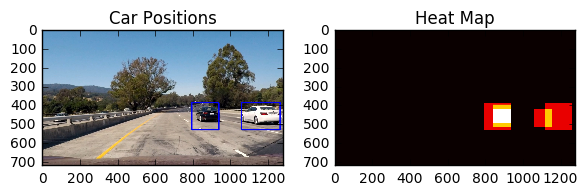

In [21]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
#box_list = pickle.load( open( "bbox_pickle.p", "rb" ))
box_list = hot_windows

# Read in image similar to one shown above 
image = mpimg.imread('test_images/test1.jpg')
hot_windows, all_windows, image_carbox = multi_scale_search(image, x_start_stops, y_start_stops, 
                   xy_windows, xy_overlaps, box_colors, debug_boxes=True)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat, hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

#### 2.3 HOG Sampling Optimization

One optimization technique mentioned in the lecture was to use sub-sample to only calculate HOG once. In theory this should speed things up but it was actually performing slower in my test. Wasn't sure what went wrong here. 

In [ ]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            # subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            # spatial_features = bin_spatial(subimg, size=spatial_size)
            # hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            # test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 320
ystop = 640
scale = 1.5
img = mpimg.imread('test_images/test1.jpg')
# draw_image = np.copy(image)
# img = img.astype(np.float32)/255

t = time.time()

out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to find cars ...')

### 3 Sliding Window Search on Video

Now put everything together, we create our image process pipeline via the `process_image` function. We are going to use a helper class to keep track of the hot windows from the last `n` video frames, in order to have a more reliable algorithm to remove false positives through heatmap/thresholding. 

The result of running the process pipeline on project_video.mp4 is [project_video_out.mp4](project_video_out.mp4)

In [22]:
from collections import deque

class DetectionBoxes:
    def __init__(self, n):
        self.n = n
        self.current_frame = None
        self.queued_frames = deque([], maxlen=n)
        self.all_boxes = []

    def add_frame(self, boxes):
        self.current_frame = boxes
        self.queued_frames.appendleft(boxes)
        #self.get_all_boxes()
        all_boxes = []
        for boxes in self.queued_frames:
            all_boxes += boxes
        if len(all_boxes) > 0:
            self.all_boxes = all_boxes
        else:
            self.all_boxes = []

detector = DetectionBoxes(10)

candidate_windows = []
for w in all_windows:
    candidate_windows += w

#print('Hot windows detected: ', len(hot_windows),', out of ', len(candidate_windows))

def process_image(image):
    # take a image and search for cars
    draw_image = np.copy(image)
    ## image = image.astype(np.float32)/255
    hot_windows = search_windows(image, candidate_windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    detector.add_frame(hot_windows)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, detector.all_boxes)
    heatmap  = apply_threshold(heatmap, 5)
    labels = label(heatmap)
    draw_image = draw_labeled_bboxes(draw_image, labels)
    return draw_image


In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("solidWhiteRight.mp4")
processed_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(video_output, audio=False)

### 4 Discussions

This is another fun project to work on where we got a chance to experiment with advanced CV algorithm (HOG extraction) and the simplicity and power of using scikit-learn's SVM module. Once you gathered all of your training images (vehicles v.s. non-vehicles), using extracted features to train the SVM is a fairly straightforward process.   

One of the more tedious aspect of this project is to fine-tune the various parameters in sliding window search. The window size, start & stop positions of the search area, overlapping ratios of the sliding windows can all impact the performance and reliability of the algorithm. Unfortunately there is no shortcut to optimization. You would just have to take the time to trial and error. 

Because we used multiple scales in sliding window search, one potential area for future work is how to determine if multiple neighboring boxes are actually identifying the same object (cars in our case) and combine these boxes into one. 

Another area of improvement would be performance. It currently takes about 1.6 seconds to process each image of size (1280x720). I understand that Python can be slow but even that I felt there should be room for improvement. 